# Acoustic Multi-Target Tracking Demo

**Based on:** Li & Coates (2017), "Particle Filtering with Invertible Particle Flow"  
**MATLAB Reference:** `PFPF/Acoustic_Example/`

This notebook demonstrates `acoustic_function.py` - a function-based implementation of the acoustic tracking model.

## Model Overview

**State (x):** `x = [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]` (4 targets with position and velocity)

**Motion model:** `x_k = Φ * x_{k-1} + w_k` (constant velocity, w_k ~ N(0, Q))

**Observation (z):** `z_s = Σ [Ψ / (r_i + d_0)] + v_s` (acoustic amplitude decays with distance, v_s ~ N(0, R))

**Key feature:** Uses two process noise matrices:
- `Q_real` (small) - for generating realistic trajectories
- `Q` (large) - for filtering with model uncertainty

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from acoustic_function import (
    initialize_acoustic_model, 
    state_transition,
    observation_model,
    simulate_trajectory
)

# Set random seed for reproducibility
tf.random.set_seed(42)

## 1. Initialize Model

The `initialize_acoustic_model()` function sets up all parameters and returns them in a dictionary.

In [2]:
# Initialize acoustic model with default parameters
model_params = initialize_acoustic_model(n_targets=4)

print("Model Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")

print("\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Model Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


### Initial State x_0

The default initial state for 4 targets (from the paper):

In [3]:
x0 = model_params['x0_initial_target_states']
print(f"Initial state x_0 shape: {x0.shape}")
print("Format: [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]\n")

x0_np = x0.numpy().flatten()
for i in range(model_params['n_targets']):
    idx = i * 4
    print(f"Target {i+1}: pos=({x0_np[idx]:.1f}, {x0_np[idx+1]:.1f}), "
          f"vel=({x0_np[idx+2]:.4f}, {x0_np[idx+3]:.4f})")

Initial state x_0 shape: (16, 1)
Format: [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]

Target 1: pos=(12.0, 6.0), vel=(0.0010, 0.0010)
Target 2: pos=(32.0, 32.0), vel=(-0.0010, -0.0050)
Target 3: pos=(20.0, 13.0), vel=(-0.1000, 0.0100)
Target 4: pos=(15.0, 35.0), vel=(0.0020, 0.0020)


## 2. State Transition and Observation

Demonstrate how to propagate the state and generate observations.

In [4]:
# Propagate state one time step: x_1 = Φ * x_0 + w
x1 = state_transition(x0, model_params, use_real_noise=True)

print("State transition (x_0 -> x_1):")
print(f"  x_0 shape: {x0.shape}")
print(f"  x_1 shape: {x1.shape}")
print(f"  Target 1 moved from ({x0_np[0]:.2f}, {x0_np[1]:.2f}) to ({x1.numpy()[0,0]:.2f}, {x1.numpy()[1,0]:.2f})")

# Generate observation: z_1 = h(x_1) + v
z1 = observation_model(x1, model_params)

print(f"\nObservation z_1 shape: {z1.shape}")
print(f"  Contains measurements from {model_params['n_sensors']} sensors")
print(f"  Sample measurements: [{z1.numpy()[0,0]:.3f}, {z1.numpy()[1,0]:.3f}, ..., {z1.numpy()[-1,0]:.3f}]")

State transition (x_0 -> x_1):
  x_0 shape: (16, 1)
  x_1 shape: (16, 1)
  Target 1 moved from (12.00, 6.00) to (12.04, 5.89)

Observation z_1 shape: (25, 1)
  Contains measurements from 25 sensors
  Sample measurements: [1.650, 2.637, ..., 1.742]


## 3. Simulate Complete Trajectory

The `simulate_trajectory()` function generates a full trajectory:
- **States:** x_0, x_1, ..., x_T (T+1 total)
- **Observations:** z_1, z_2, ..., z_T (T total)

Note: x_0 has no corresponding observation (initial state only).

In [7]:
tf.random.set_seed(42)
# Simulate trajectory (40 time steps as in the paper)
T = 40
states, observations = simulate_trajectory(model_params, T, keep_in_bounds=True)

print(f"Trajectory Generated:")
print(f"  States (x) shape: {states.shape}")
print(f"    - Contains: x_0, x_1, ..., x_{T} ({T+1} state vectors)")
print(f"    - Each column is a {model_params['state_dim']}-dim state vector")

print(f"\n  Observations (z) shape: {observations.shape}")
print(f"    - Contains: z_1, z_2, ..., z_{T} ({T} observation vectors)")
print(f"    - Each column is a {model_params['n_sensors']}-dim measurement vector")

Trajectory Generated:
  States (x) shape: (16, 41)
    - Contains: x_0, x_1, ..., x_40 (41 state vectors)
    - Each column is a 16-dim state vector

  Observations (z) shape: (25, 40)
    - Contains: z_1, z_2, ..., z_40 (40 observation vectors)
    - Each column is a 25-dim measurement vector


## 4. Visualize Results

Plot the generated trajectories and sensor measurements.

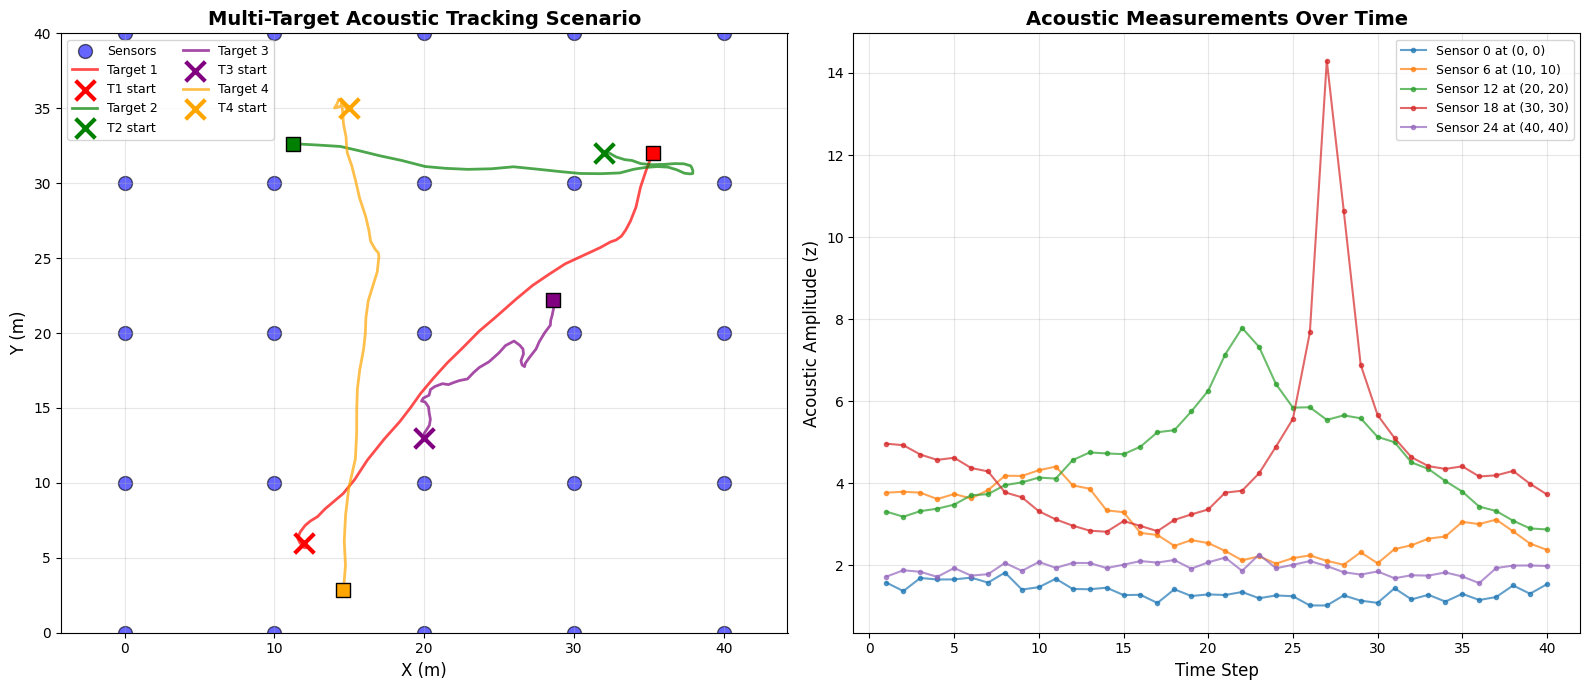


Note: Sensors closer to targets show higher amplitude measurements


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ============================================================
# Plot 1: Target trajectories and sensor positions
# ============================================================
ax = axes[0]
sensor_pos = model_params['sensor_positions'].numpy()
states_np = states.numpy()

# Plot sensors
ax.scatter(sensor_pos[:, 0], sensor_pos[:, 1], c='blue', marker='o', 
           s=100, label='Sensors', alpha=0.6, edgecolors='black', zorder=1)

# Plot trajectories for each target
colors = ['red', 'green', 'purple', 'orange']
for i in range(model_params['n_targets']):
    # Extract x and y coordinates for target i
    # State format: [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]
    x_traj = states_np[i * 4, :]      # x-positions over time
    y_traj = states_np[i * 4 + 1, :]  # y-positions over time
    
    ax.plot(x_traj, y_traj, '-', color=colors[i], linewidth=2, 
            label=f'Target {i+1}', alpha=0.7, zorder=2)
    ax.scatter(x_traj[0], y_traj[0], color=colors[i], marker='x', 
               s=200, linewidths=3, zorder=3, label=f'T{i+1} start')
    ax.scatter(x_traj[-1], y_traj[-1], color=colors[i], marker='s', 
               s=100, edgecolors='black', zorder=3)

ax.set_xlabel('X (m)', fontsize=12)
ax.set_ylabel('Y (m)', fontsize=12)
ax.set_title('Multi-Target Acoustic Tracking Scenario', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.axis('equal')
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])

# ============================================================
# Plot 2: Observations (z) over time
# ============================================================
ax = axes[1]
obs_np = observations.numpy()

# Plot measurements from 5 representative sensors
# Sensors: 0=(0,0), 6=(10,10), 12=(20,20), 18=(30,30), 24=(40,40)
sensor_indices = [0, 6, 12, 18, 24]
for idx in sensor_indices:
    ax.plot(range(1, T+1), obs_np[idx, :], '-o', 
            label=f'Sensor {idx} at ({sensor_pos[idx, 0]:.0f}, {sensor_pos[idx, 1]:.0f})',
            alpha=0.7, markersize=3)

ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Acoustic Amplitude (z)', fontsize=12)
ax.set_title('Acoustic Measurements Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("\nNote: Sensors closer to targets show higher amplitude measurements")